# Building A Linear Regression Model That Predicts Retail Customer Spending

We will create a complete project trying to predict customer spending using linear regression with Python.

In this exercise, we have some historical transaction data from 2010 and 2011. For each transaction, we have a customer identifier (CustomerID), the number of units purchased (Quantity), the date of purchase (InvoiceDate) and the unit cost (UnitPrice), as well as some other information about the purchased item.

For this Notebook you'll find the dataset once <a href="https://www.narrativetext.co/pricing" target="_blank">you subscribe to our service here</a> 

We want to prepare this data for a regression of 2010 customer transaction data against 2011 expenses. Therefore, we will create features from the 2010 data and calculate the target (the amount of money spent) for 2011.

When we create this model, it should generalize to future years for which we do not yet have the result. Therefore, we could use 2020 data to predict 2021 spending behavior in advance, unless the market or business has changed significantly since the time period to which the data used to fit the model refers:

In [1]:
import pandas as pd

df = pd.read_csv('datasets/retail_transactions.csv')

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-03-16 11:36:00,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2011-07-13 12:18:00,1.25,16225.0,United Kingdom
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-04-01 13:20:00,0.85,12949.0,United Kingdom
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2011-01-09 15:23:00,2.95,14395.0,United Kingdom
4,561390,20726,LUNCH BAG WOODLAND,10,2011-07-27 09:52:00,1.65,17068.0,United Kingdom


Convert the InvoiceDate column to date format using the following code:

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-03-16 11:36:00,1.25,18231.0,United Kingdom
1,559898,21868,POTTING SHED TEA MUG,6,2011-07-13 12:18:00,1.25,16225.0,United Kingdom
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-04-01 13:20:00,0.85,12949.0,United Kingdom
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2011-01-09 15:23:00,2.95,14395.0,United Kingdom
4,561390,20726,LUNCH BAG WOODLAND,10,2011-07-27 09:52:00,1.65,17068.0,United Kingdom


Calculate the revenue for each row by multiplying the quantity by the unit price:

In [6]:
df['revenue'] = df['UnitPrice']*df['Quantity']

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,546729,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-03-16 11:36:00,1.25,18231.0,United Kingdom,15.0
1,559898,21868,POTTING SHED TEA MUG,6,2011-07-13 12:18:00,1.25,16225.0,United Kingdom,7.5
2,548648,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-04-01 13:20:00,0.85,12949.0,United Kingdom,20.4
3,540543,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,4,2011-01-09 15:23:00,2.95,14395.0,United Kingdom,11.8
4,561390,20726,LUNCH BAG WOODLAND,10,2011-07-27 09:52:00,1.65,17068.0,United Kingdom,16.5


You will notice that each invoice is spread over several rows, one for each type of product purchased. These can be combined in such a way that the data for each transaction is in a single row. To do this, we can perform a grouped operation on `InvoiceNo`. However, before that, we need to specify how to combine those rows that are grouped. Use the following code:

In [8]:
operations = {'revenue':'sum',
              'InvoiceDate':'first',
              'CustomerID':'first' 
             }

df = df.groupby('InvoiceNo').agg(operations)

In [9]:
df.head()

,revenue,InvoiceDate,CustomerID
InvoiceNo,,,
536365,139.12,2010-12-01 08:26:00,17850.0
536366,22.20,2010-12-01 08:28:00,17850.0
536367,278.73,2010-12-01 08:34:00,13047.0
536368,70.05,2010-12-01 08:34:00,13047.0
536369,17.85,2010-12-01 08:35:00,13047.0


In the preceding code snippet, we first specify the aggregation functions we will use for each column, and then perform the grouping and apply those functions. InvoiceDate and CustomerID will be the same for all rows of the same invoice, so we can only take the first entry for them. For revenue, we sum the revenue for all items on the same invoice to get the total revenue for that invoice.

Since we will be using the year to decide which rows are being used for prediction and which ones we are predicting, create a separate column called year for the year, as follows:

In [10]:
df['year'] = df['InvoiceDate'].apply(lambda x: x.year)

In [11]:
df.head()

,revenue,InvoiceDate,CustomerID,year
InvoiceNo,,,,
536365,139.12,2010-12-01 08:26:00,17850.0,2010
536366,22.20,2010-12-01 08:28:00,17850.0,2010
536367,278.73,2010-12-01 08:34:00,13047.0,2010
536368,70.05,2010-12-01 08:34:00,13047.0,2010
536369,17.85,2010-12-01 08:35:00,13047.0,2010


Transaction dates can also be an important source of characteristics. The days from a customer's last transaction to the end of the year, or how early a customer had their first transaction, can tell us a bit about the customer's purchase history, which could be important. Therefore, for each transaction, we will calculate how many days difference there is between the last day of 2010 and the date of the invoice:

In [12]:
df['days_since'] = (pd.datetime(year=2010, month=12, day=31) - 
                    df['InvoiceDate']).apply(lambda x: x.days)

/home/daniel/Desktop/narrativetext_project/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [13]:
df.head()

,revenue,InvoiceDate,CustomerID,year,days_since
InvoiceNo,,,,,
536365,139.12,2010-12-01 08:26:00,17850.0,2010,29
536366,22.20,2010-12-01 08:28:00,17850.0,2010,29
536367,278.73,2010-12-01 08:34:00,13047.0,2010,29
536368,70.05,2010-12-01 08:34:00,13047.0,2010,29
536369,17.85,2010-12-01 08:35:00,13047.0,2010,29


Currently, we have the data grouped by invoice, but we really want it to be grouped by customer. 

We'll start by calculating all of our predictors. We will again define a set of aggregation functions for each of our variables and apply them using groupby. We will calculate the sum of the revenues. 

For `days_since`, we will calculate the maximum and minimum number of days (giving us features that tell us how long this customer has been active in 2010, and how recently), as well as the number of unique values (giving us how many days apart this customer made a purchase). Since these are for our forecasters, we will only apply these functions to our data from 2010, and store them in a variable, X, and use the `head` function to see the results:

In [14]:
operations = {'revenue':'sum',
              'days_since':['max','min','nunique'],
             }

X = df[df['year'] == 2010].groupby('CustomerID').agg(operations)

In [15]:
X.head()

revenue days_since            
                sum        max min nunique
CustomerID                                
12347.0      711.79         23  23       1
12348.0      892.80         14  14       1
12370.0     1868.02         16  13       2
12377.0     1001.52         10  10       1
12383.0      600.72          8   8       1

As you can see in the figure above, since we perform multiple types of aggregations on the `days_since` column, we end up with multi-level column labels. To simplify this, we can rescale the column names for easy reference later. Use the following code and print the results:

In [16]:
X.columns = [' '.join(col).strip() for col in X.columns.values]

In [17]:
X.head()

,revenue sum,days_since max,days_since min,days_since nunique
CustomerID,,,,
12347.0,711.79,23,23,1
12348.0,892.80,14,14,1
12370.0,1868.02,16,13,2
12377.0,1001.52,10,10,1
12383.0,600.72,8,8,1


Let's calculate one more characteristic: the average expense per order. We can calculate this by dividing the sum of the revenue by `days_since_nunique` (this is actually the average spend per day, not per order, but we are assuming that if two orders were placed on the same day, we can treat them as part of the same order for our purposes):

In [18]:
X['avg_order_cost'] = X['revenue sum']/X['days_since nunique']

In [19]:
X.head()

,revenue sum,days_since max,days_since min,days_since nunique,avg_order_cost
CustomerID,,,,,
12347.0,711.79,23,23,1,711.79
12348.0,892.80,14,14,1,892.80
12370.0,1868.02,16,13,2,934.01
12377.0,1001.52,10,10,1,1001.52
12383.0,600.72,8,8,1,600.72


Now that we have our forecasters, we need the result we will predict, which is just the sum of the revenues for 2011. We can calculate it with a simple groupby and store the values in the variable y, as follows:

In [20]:
y = df[df['year'] == 2011].groupby('CustomerID')['revenue'].sum()

In [21]:
y

CustomerID
12346.0    77183.60
12347.0     3598.21
12348.0      904.44
12349.0     1757.55
12350.0      334.40
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2094.88
18287.0     1837.28
Name: revenue, Length: 4219, dtype: float64

Now we can put our predictors and results into a single DataFrame, `wrangled_df`, and rename the columns to have more intuitive names. Finally, look at the resulting DataFrame, using the `head` function:

In [22]:
wrangled_df = pd.concat([X,y], axis=1)
wrangled_df.columns = ['2010 revenue',
                       'days_since_first_purchase',
                       'days_since_last_purchase',
                       'number_of_purchases',
                       'avg_order_cost',
                       '2011 revenue']

In [23]:
wrangled_df.head()

,2010 revenue,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue
CustomerID,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,77183.60
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12349.0,NaN,NaN,NaN,NaN,NaN,1757.55
12350.0,NaN,NaN,NaN,NaN,NaN,334.40


Note that many of the values in our DataFrame are `NaN`. This is caused by clients that were active only in 2010 or only in 2011, so there is no data for the other year. Later we will work on predicting which of our customers will churn, but for now, we will just drop all customers that are not active in both years. Note that this means that our model will predict customer spending in the next year assuming they are still active customers. To remove customers with no values, we will remove rows where any of the revenue columns are null, as follows:

In [24]:
wrangled_df = wrangled_df[~wrangled_df['2010 revenue'].isnull()]
wrangled_df = wrangled_df[~wrangled_df['2011 revenue'].isnull()]

In [25]:
wrangled_df.head()

,2010 revenue,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


As a final data cleaning step, it is often a good idea to get rid of outliers. A standard definition is that an outlier is any data point that is more than three standard deviations above the median, so we will use this to remove clients that are outliers in terms of 2010 or 2011 revenue:

In [26]:
wrangled_df = wrangled_df[wrangled_df['2011 revenue'] 
                          < ((wrangled_df['2011 revenue'].median()) 
                             + wrangled_df['2011 revenue'].std()*3)]

In [27]:
wrangled_df = wrangled_df[wrangled_df['2010 revenue'] 
                          < ((wrangled_df['2010 revenue'].median()) 
                             + wrangled_df['2010 revenue'].std()*3)] 

In [28]:
wrangled_df.head()

,2010 revenue,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue
CustomerID,,,,,,
12347.0,711.79,23.0,23.0,1.0,711.79,3598.21
12348.0,892.80,14.0,14.0,1.0,892.80,904.44
12370.0,1868.02,16.0,13.0,2.0,934.01,1677.67
12377.0,1001.52,10.0,10.0,1.0,1001.52,626.60
12383.0,600.72,8.0,8.0,1.0,600.72,1249.84


It is often a good idea, after you have done the data cleanup and feature engineering, to save the new data as a new file so that, as you develop the model, you do not need to run the data through the entire feature engineering and cleanup pipeline every time you want to rerun the code. We can do this using the `to_csv` function. 

In [29]:
wrangled_df.to_csv('datasets/wrangled_transactions.csv')

## Examining the relationships between the predictors and the outcome.

In this exercise, we will use the characteristics we calculated in the previous exercise and see if these variables have any relationship with our outcome of interest (customer sales revenue in 2011):

Using pandas to import the data you saved at the end of the last exercise, using CustomerID as the index:

In [30]:
df = pd.read_csv('datasets/wrangled_transactions.csv', index_col='CustomerID')

The seaborn library has a number of plotting features. Its pair plot feature will plot histograms and pairwise scatter plots of all our variables on one line, allowing us to easily examine both the distributions of our data and the relationships between data points. Use the following code:

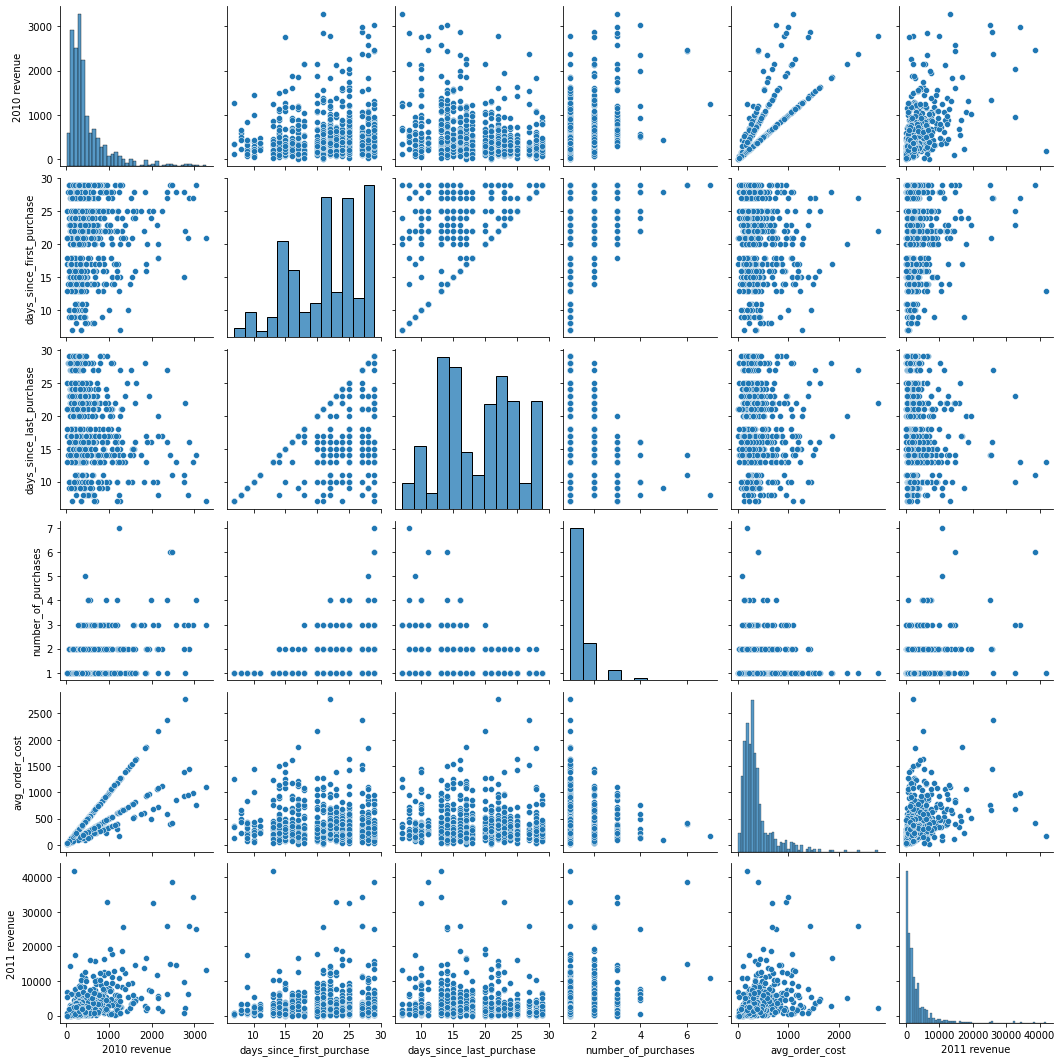

In [31]:
import seaborn as sns
%matplotlib inline

sns.pairplot(df)

In the diagram above, the diagonal shows a histogram for each variable, while each row shows the scatter plot between one variable and the other. The bottom row of figures shows the scatter plots of 2011 income (our outcome of interest) against each of the other variables. Because the data points overlap and there is a fair amount of variation, the relationships do not appear very clear in the visualizations.

Therefore, we can use correlations to help us interpret the relationships. The `corr` function of pandas will generate correlations between all the variables in a DataFrame:

In [32]:
df.corr()

,2010 revenue,days_since_first_purchase,days_since_last_purchase,number_of_purchases,avg_order_cost,2011 revenue
2010 revenue,1.000000,0.109692,-0.254964,0.504438,0.779401,0.548234
days_since_first_purchase,0.109692,1.000000,0.641574,0.327502,-0.074321,0.061743
days_since_last_purchase,-0.254964,0.641574,1.000000,-0.398268,-0.054051,-0.171294
number_of_purchases,0.504438,0.327502,-0.398268,1.000000,-0.012466,0.355751
avg_order_cost,0.779401,-0.074321,-0.054051,-0.012466,1.000000,0.357384
2011 revenue,0.548234,0.061743,-0.171294,0.355751,0.357384,1.000000


Again, we can look at the last row to see the relationships between our forecasters and the interest result (2011 revenue). Positive numbers indicate a positive relationship, e.g., the higher a client's 2010 income, the higher their expected income in 2011. Negative numbers mean the opposite, e.g., the more days since a customer's last purchase, the lower the revenue expectation for 2011. Also, the higher the absolute number, the stronger the relationship.

The resulting correlations should make sense. The more competitors in the area, the lower a location's revenue, while median income, loyalty members and population density are all positively related. The age of a place is also positively correlated with revenue, indicating that the longer a place is open, the better known it is and the more customers it attracts (or perhaps, only places that do well last a long time).

## Building a linear model that predicts customer spending.

In this exercise, we will build a linear model on customer spending using the features created in the previous exercise:

Recall that there is only a weak relationship between `days_since_first_purchase` and 2011 revenue-so we will not include that predictor in our model.

Store the predictor columns and the outcome columns in the X and y variables, respectively:

In [33]:
X = df[['2010 revenue',
       'days_since_last_purchase',
       'number_of_purchases',
       'avg_order_cost'
       ]]

In [34]:
y = df['2011 revenue']

We use sklearn to perform a split of the data, so that we can evaluate the model on a dataset on which it was not trained, as shown here:

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

We import LinearRegression from sklearn, create a LinearRegression model and adjust the training data:

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
model = LinearRegression()

In [38]:
model.fit(X_train,y_train)

LinearRegression()

We examine the coefficients of the model by checking the `coef_` property. Note that these are in the same order as our X columns: 2010 revenue, days since last purchase, number of purchases and average order cost:

In [39]:
model.coef_

array([  5.78799016,   7.47737544, 336.60769871,  -2.0558923 ])

Check the intercept term of the model by checking the `intercept_` property:

In [40]:
model.intercept_

264.8693265705956

Now we can use the fitted model to make predictions about a customer outside our data set.

Make a DataFrame containing a customer's data, where the 2010 revenue is 1,000, the number of days since last purchase is 20, the number of purchases is 2, and the average order cost is 500. Have the model make a prediction on this customer's data:

In [41]:
single_customer = pd.DataFrame({
    '2010 revenue': [1000],
    'days_since_last_purchase': [20],
    'number_of_purchases': [2],
    'avg_order_cost': [500]
})

In [42]:
single_customer

,2010 revenue,days_since_last_purchase,number_of_purchases,avg_order_cost
0,1000,20,2,500


In [43]:
model.predict(single_customer)

array([5847.67624446])

We can plot the model predictions in the test set against the actual value. First, we import matplotlib, and make a scatter plot of the model predictions in X_test against y_test.

Constrain the x and y axes to a maximum value of 10,000 so that we have a better view of where most of the data points are located.

Finally, add a line with slope 1, which will serve as our reference: if all points lie on this line, it means that we have a perfect relationship between our predictions and the true response:

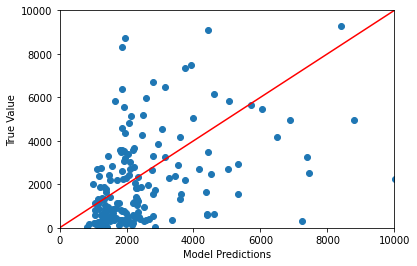

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(model.predict(X_test),y_test)
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.plot([0, 10000], [0, 10000], 'k-', color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Value')
plt.show()

In the graph above, the red line indicates where the points would be if the prediction were the same as the actual value. Since many of our points are quite far from the red line, this indicates that the model is not completely accurate. However, there does appear to be some relationship, as higher model predictions have higher true values.

To further examine the relationship, we can use correlation. From scipy, we can import the pearsonr function, which calculates the correlation between two matrices, just as we did with Pandas for our entire DataFrame. We can use it to calculate the correlation between our model predictions and the actual value as follows:

In [45]:
from scipy.stats.stats import pearsonr

In [46]:
pearsonr(model.predict(X_test),y_test)

(0.6125740076680493, 1.934002067463782e-20)

You should have two numbers returned: (0.612574007666680493, 1.934002067463782e-20). The first number is the correlation, which is close to 0.6, indicating a strong relationship. The second number is the p-value, which indicates the probability of seeing such a strong relationship if the two sets of numbers were unrelated; the very low number here means that this relationship is unlikely to be due to chance.

## Conclusion

We have constructed a simple example of linear regression. You could try this same one with Decision Trees and review the differences in the models. Later we will create another article to understand how to do this.